# Model Training for Car Price Prediction of Germany from Autoscout24
AutoScout24 is one of the largest Europe's car market for new and used cars. We've collected car data from 2011 to 2021. It shows basic fields like make, model, mileage, horse power, etc. Link for the dataset https://www.kaggle.com/datasets/ander289386/cars-germany

### 1 Import of Data and Required Packages

In [3]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

Import the CSV Data as Pandas DataFrame

In [4]:
df = pd.read_csv('data/autoscout24-germany-dataset.csv')
df.head()

,mileage,make,model,fuel,gear,offerType,price,hp,year
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011


In [5]:
# Let's find out a bit more about the variables in the dataframe:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46405 entries, 0 to 46404
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    46405 non-null  int64  
 1   make       46405 non-null  object 
 2   model      46262 non-null  object 
 3   fuel       46405 non-null  object 
 4   gear       46223 non-null  object 
 5   offerType  46405 non-null  object 
 6   price      46405 non-null  int64  
 7   hp         46376 non-null  float64
 8   year       46405 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.2+ MB


Check Missing values

In [6]:
df.isna().sum()

mileage        0
make           0
model        143
fuel           0
gear         182
offerType      0
price          0
hp            29
year           0
dtype: int64

Replacing the year variable with the age of the vehicles

In [7]:
from datetime import datetime

# Create a new column: 'age'
df['age'] = datetime.now().year - df['year']

# Drop the 'year' column
df = df.drop('year', axis=1)

# Show the top five rows of the cars dataset
df.head()

,mileage,make,model,fuel,gear,offerType,price,hp,age
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,12
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,12
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,12
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,12
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,12


In [8]:
# Drop the rows with null values
df = df.dropna()

# Display the total number of null values in the resulting dataframe
df.isna().sum()

mileage      0
make         0
model        0
fuel         0
gear         0
offerType    0
price        0
hp           0
age          0
dtype: int64

In [9]:
# It's also a good idea to drop duplicate rows:
df = df.drop_duplicates(keep='first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43947 entries, 0 to 46399
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    43947 non-null  int64  
 1   make       43947 non-null  object 
 2   model      43947 non-null  object 
 3   fuel       43947 non-null  object 
 4   gear       43947 non-null  object 
 5   offerType  43947 non-null  object 
 6   price      43947 non-null  int64  
 7   hp         43947 non-null  float64
 8   age        43947 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.4+ MB


### 2 Preparing X and Y variables and Transformation

In [10]:
X = df.drop(columns=['price'],axis=1)
X.head()

,mileage,make,model,fuel,gear,offerType,hp,age
0,235000,BMW,316,Diesel,Manual,Used,116.0,12
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,122.0,12
2,149300,SEAT,Exeo,Gasoline,Manual,Used,160.0,12
3,96200,Renault,Megane,Gasoline,Manual,Used,110.0,12
4,156000,Peugeot,308,Gasoline,Manual,Used,156.0,12


In [11]:
y = df['price']
y

0         6800
1         6877
2         6900
3         6950
4         6950
         ...  
46394    12340
46396    12490
46397    12805
46398    12805
46399    12980
Name: price, Length: 43947, dtype: int64

In [12]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [13]:
X = preprocessor.fit_transform(X)

In [14]:
X.shape

(43947, 928)

In [15]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((35157, 928), (8790, 928))

### 3 Create an Evaluate Function to give all metrics after model Training

In [16]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [17]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5184.9856
- Mean Absolute Error: 2653.4610
- R2 Score: 0.9330
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6120.7414
- Mean Absolute Error: 2877.8560
- R2 Score: 0.8690


Lasso
Model performance for Training set
- Root Mean Squared Error: 5440.0612
- Mean Absolute Error: 2899.3985
- R2 Score: 0.9262
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6095.9892
- Mean Absolute Error: 3046.4881
- R2 Score: 0.8701


Ridge
Model performance for Training set
- Root Mean Squared Error: 6191.4006
- Mean Absolute Error: 2896.1297
- R2 Score: 0.9045
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5899.2937
- Mean Absolute Error: 3048.8048
- R2 Score: 0.8783


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 7216.5261
- Mean Absolute Error: 1666.4141


### 4 Results of the models

In [20]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
7,CatBoosting Regressor,0.937994
5,Random Forest Regressor,0.925914
6,XGBRegressor,0.910926
3,K-Neighbors Regressor,0.891959
4,Decision Tree,0.889888
2,Ridge,0.878302
1,Lasso,0.870051
0,Linear Regression,0.868993
8,AdaBoost Regressor,0.644085


Linear Regression

In [21]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 86.90


Plot y_pred and y_test

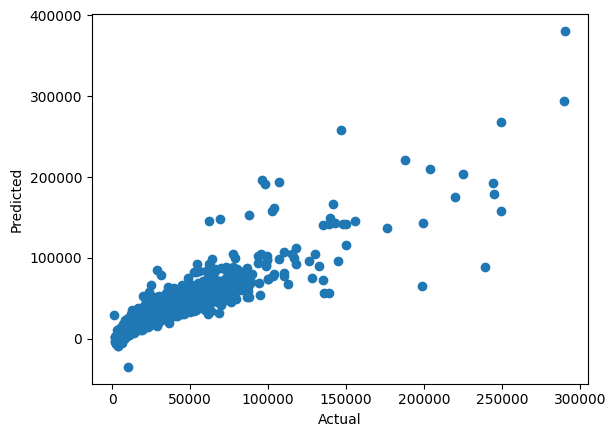

In [22]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

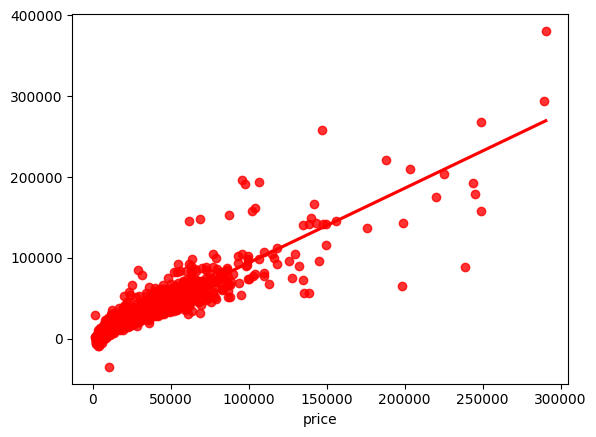

In [23]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

Difference between Actual and Predicted Values

In [24]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
39751,8850,6820.115828,2029.884172
20003,13900,17485.483552,-3585.483552
15477,13490,13168.285399,321.714601
9106,5400,2120.235443,3279.764557
7959,9800,10924.711665,-1124.711665
...,...,...,...
23730,5950,7163.207713,-1213.207713
39611,9999,10163.845217,-164.845217
13184,11330,12008.847025,-678.847025
18543,8450,10083.316378,-1633.316378
